In [1]:
from MALDINet import _MALDINet
from utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='3'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_2 共1个任务（已分好训练集和测试集）

### 1. 25峰值测试

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data2/peaks_25.csv', t = True)
Y = np.zeros((198,2))                                             #将标签以独热编码的形式存起来
for i in range (0,101):                                           #阴性101例
    Y[i,0] = 1                                                    #阴性标签为0
for i in range (101,198):                                         #阳性97例
    Y[i,1] = 1                                                    #阳性标签为1
y = Y.astype(int)

Y = np.zeros(198)                                                 #用于分层的标签
for i in range (0,101):                                           #阴性101例
    Y[i] = 0                                                    
for i in range (101,198):                                          #阳性97例
    Y[i] = 1
Y = Y.astype(int)
dfx

,5158.0,5366.0,5893.0,6357.0,6654.0,6939.0,7364.0,7614.0,8034.0,8043.0,...,13719.0,13765.0,13886.0,14049.0,14095.0,14102.0,15123.0,15867.0,28091.0,28232.0
0,0.915378,2.119881,-6.373076,2.895233,4.745626,4.959308,1.609087,3.684716,2.002649,1.704424,...,1.747955,5.329292,5.055243,4.196850,2.644516,2.435353,3.481493,4.304331,3.806436,2.764832
1,0.346961,2.089905,3.551216,2.747880,4.250817,3.875808,0.676483,2.971832,2.691183,2.330817,...,0.602879,4.196850,3.914918,3.684716,2.162612,1.545380,3.657197,4.611486,3.576894,1.733080
2,0.197533,2.199390,4.363039,2.971832,3.954865,4.147989,0.742380,2.517331,1.449438,0.969174,...,1.066917,3.999475,4.482156,3.417300,2.675308,2.236886,0.577868,1.430000,2.299408,1.457707
3,2.828014,0.803187,2.740260,1.649892,3.288986,3.713046,1.811242,3.379678,-0.263247,0.378706,...,1.094680,3.684716,4.147989,3.326123,2.293413,1.859842,0.676483,1.050654,2.628511,0.700641
4,0.155445,2.374500,1.733080,3.773321,4.959308,4.682115,0.676483,2.916457,1.674478,1.665953,...,1.971704,5.926340,5.329292,5.657684,3.379678,3.326123,1.859842,3.458778,4.611486,2.782478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,2.590459,3.019337,1.560783,1.081098,4.196850,4.482156,1.577338,4.041882,3.343678,2.707102,...,1.747955,4.363039,3.875808,-0.421262,1.704424,1.001842,4.891189,5.657684,3.632906,1.696599
194,2.938249,2.927811,1.018215,2.114141,3.713046,3.046261,1.939591,3.806436,3.019337,2.865366,...,1.286173,4.422610,3.841583,4.682115,1.688783,1.274780,5.055243,5.434740,3.254390,2.236886
195,3.681778,2.737958,1.922076,2.044530,3.189809,2.672848,2.105270,4.300708,4.038459,3.629718,...,0.349276,3.548042,3.499952,3.522008,1.422399,1.620360,5.326150,5.787063,2.618771,1.882689
196,2.949569,3.360486,2.553690,2.156038,4.196850,4.250817,2.009107,5.228747,2.048041,3.007488,...,1.297306,5.055243,4.539580,4.891189,2.414357,2.407690,3.954865,4.823741,3.632906,1.457707


In [6]:
dfx_test = LoadMSData(root_path = root_path, data_path = 'data2/test_25.csv', t = True)
test_Y = np.zeros(100)                                        
for i in range (0,51):                                            #阴性51例
    test_Y[i] = 0                                               #阴性标签为0
for i in range (51,100):                                          #阳性49例
    test_Y[i] = 1                                               #阳性标签为1
test_y = test_Y.astype(int)
dfx_test

,5158.0,5366.0,5893.0,6357.0,6654.0,6939.0,7364.0,7614.0,8034.0,8043.0,...,13719.0,13765.0,13886.0,14049.0,14095.0,14102.0,15123.0,15867.0,28091.0,28232.0
0,-3.028828,2.054368,1.560783,2.628511,4.482156,4.611486,1.740307,2.818366,1.457707,1.634111,...,1.919286,5.537255,4.959308,4.422610,2.211303,1.696599,3.084832,3.657197,3.713046,1.971704
1,1.308344,2.476253,-1.332072,2.995370,4.539580,3.914918,1.001842,2.590459,2.636307,1.846561,...,1.811242,4.745626,4.250817,4.304331,2.441844,2.035393,3.632906,4.482156,4.041882,2.318426
2,-3.028828,2.949569,1.001842,3.134478,5.055243,4.891189,1.971704,3.806436,2.174698,1.641607,...,1.733080,5.926340,5.329292,4.304331,2.855613,2.205223,3.742589,4.682115,3.713046,2.299408
3,0.469377,2.621033,1.251965,3.046261,5.329292,2.960085,1.696599,1.804293,1.513093,1.081098,...,-0.341492,4.147989,4.041882,4.093537,2.260895,0.915378,1.634111,2.598020,3.326123,1.887004
4,0.016311,2.193723,1.001842,2.809109,4.422610,4.611486,1.513093,2.782478,1.811242,0.237026,...,2.174698,5.657684,4.745626,4.891189,2.230228,2.211303,2.096333,3.254390,4.250817,2.401560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.058616,3.458778,2.846576,3.397883,4.959308,4.363039,1.592961,4.823741,3.110719,3.134478,...,0.493450,4.041882,3.841583,2.517331,2.096333,0.897148,5.228747,5.926340,3.657197,2.180747
96,3.176068,3.046261,2.299408,2.009107,2.448805,4.611486,1.626435,4.250817,3.742589,3.379678,...,-0.141523,4.682115,4.745626,2.125634,1.769630,0.524957,5.537255,6.255487,3.524717,1.592961
97,3.097380,2.949569,2.621033,1.718936,2.905597,2.531318,2.497314,4.482156,3.684716,3.632906,...,1.286173,3.773321,3.326123,3.058616,0.676483,0.550624,4.745626,5.329292,2.916457,1.740307
98,3.684716,3.502589,1.430000,2.096333,3.379678,3.551216,1.789565,4.147989,3.773321,3.657197,...,1.108988,5.228747,3.999475,4.482156,1.852797,1.733080,5.434740,5.657684,3.326123,1.592961


In [8]:
mp = AggMap(dfx, metric = 'euclidean')                          #使用欧式距离
mp.fit(cluster_channels=5, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data2', file_type = 'aggmap', file_name = 'aggmap_25peaks.mp')

2023-12-25 17:21:08,597 - INFO - [bidd-aggmap] - Calculating distance ...
2023-12-25 17:21:08,605 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 25/25 [00:00<00:00, 619.52it/s]


2023-12-25 17:21:09,323 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2023-12-25 17:21:09,378 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2023-12-25 17:21:09,393 - INFO - [bidd-aggmap] - Finished


In [10]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
test_X = mp.batch_transform(dfx_test.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 100/100 [00:00<00:00, 431.00it/s]


Auc =  0.9897959183673469
Acc =  0.99
f1_score =  0.99
average_precision =  0.99
recall_score =  0.99


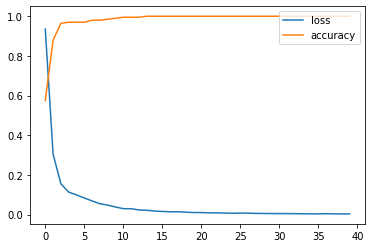

In [19]:
#三核 单层dense结果
clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',dense_layers=[32], dropout = 0)
opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
history = clf.fit(X, y, batch_size=128, epochs=40, verbose=0)

probs = clf.predict(test_X)
y_pred = np.argmax(probs, axis=1)
#MADLINet Test Metrics
auc = roc_auc_score(test_y, y_pred)
acc = accuracy_score(test_y,y_pred)
rec = recall_score(test_y, y_pred,average="micro")
f1 = f1_score(test_y, y_pred,average="micro")
pr = precision_score(test_y, y_pred,average="micro")
print("Auc = ",auc)
print("Acc = ",acc)
print("f1_score = ",f1)
print("average_precision = ",pr)
print("recall_score = ",rec)
#plot train curve
PlotCurve(history)

Auc =  0.9897959183673469
Acc =  0.99
f1_score =  0.99
average_precision =  0.99
recall_score =  0.99


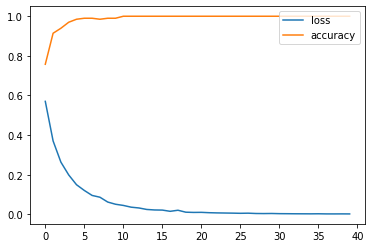

In [26]:
#三核 多层dense结果
clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',dense_layers=[256,128,64,32], dropout = 0)
opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
history = clf.fit(X, y, batch_size=128, epochs=40, verbose=0)

probs = clf.predict(test_X)
y_pred = np.argmax(probs, axis=1)
#MADLINet Test Metrics
auc = roc_auc_score(test_y, y_pred)
acc = accuracy_score(test_y,y_pred)
rec = recall_score(test_y, y_pred,average="micro")
f1 = f1_score(test_y, y_pred,average="micro")
pr = precision_score(test_y, y_pred,average="micro")
print("Auc = ",auc)
print("Acc = ",acc)
print("f1_score = ",f1)
print("average_precision = ",pr)
print("recall_score = ",rec)
#plot train curve
PlotCurve(history)

In [27]:
clf.save('/mnt/lzyt/SmallSamples/data2/model/model_25peaks_MK.h5')

### 2. 386全峰值测试

In [28]:
dfx = LoadMSData(root_path = root_path, data_path = 'data2/peaks.csv', t = True)
dfx_test = LoadMSData(root_path = root_path, data_path = 'data2/test.csv', t = True)

In [29]:
mp = AggMap(dfx, metric = 'euclidean')                          #使用欧式距离
mp.fit(cluster_channels=5, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data2', file_type = 'aggmap', file_name = 'aggmap_386peaks.mp')

2023-12-25 18:13:09,384 - INFO - [bidd-aggmap] - Calculating distance ...
2023-12-25 18:13:09,402 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 386/386 [00:00<00:00, 547.09it/s]


2023-12-25 18:13:15,203 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2023-12-25 18:13:15,991 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2023-12-25 18:13:16,299 - INFO - [bidd-aggmap] - Finished


In [30]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
test_X = mp.batch_transform(dfx_test.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_mouse_skin_0.2.dat')

100%|##########| 100/100 [00:00<00:00, 340.75it/s]


Auc =  0.9803921568627452
Acc =  0.98
f1_score =  0.98
average_precision =  0.98
recall_score =  0.98


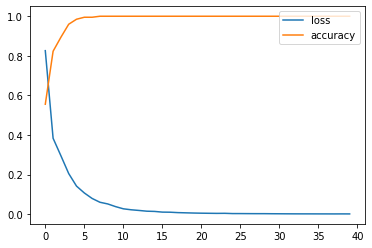

In [125]:
#三核 多层dense结果
tf.compat.v1.set_random_seed(22)
clf = _MALDINet(X.shape[1:], n_outputs = y.shape[-1], kernel_block='MK',dense_layers=[128], dropout = 0)
opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
clf.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
history = clf.fit(X, y, batch_size=128, epochs=40, verbose=0)

probs = clf.predict(test_X)
y_pred = np.argmax(probs, axis=1)
#MADLINet Test Metrics
auc = roc_auc_score(test_y, y_pred)
acc = accuracy_score(test_y,y_pred)
rec = recall_score(test_y, y_pred,average="micro")
f1 = f1_score(test_y, y_pred,average="micro")
pr = precision_score(test_y, y_pred,average="micro")
print("Auc = ",auc)
print("Acc = ",acc)
print("f1_score = ",f1)
print("average_precision = ",pr)
print("recall_score = ",rec)
#plot train curve
PlotCurve(history)

In [126]:
clf.save('/mnt/lzyt/SmallSamples/data2/model/model_386peaks_MK.h5')